In [6]:
from routing_game_utils import *

import networkx as nx
from itertools import product
from typing import List, Tuple, Dict
import json
import random
import sympy as sp
import numpy as np

In [3]:
def brute_force(G: nx.DiGraph, source_sink_pairs: List[Tuple[int, int]], demands: List[int], latency_functions: Dict):
    # each player's strategy set is represented as a set of available paths from their source to their sink
    paths = get_strategy_sets(G, source_sink_pairs)

    # flow: index represents a player (player 0 = source_sink_pair[0], etc)
    # value represents an path index for that player
    min_total_latency = float('inf')
    best_flow = None # best flow is the one that minimizes total latency

    # map a flow tuple to a map detailing the latency each player suffers in the flow
    # key: flow tuple, value: map of player : player_latency
    equil_lookup = {}

    # list of all flow tuples (need tuples for map lookup)
    # TODO: calculate product(...) and store in all_flows directly, rather than building all_flows one by one
    all_flows = []
    
    for flow in product(*[[i for i in range(len(path))] for idx, path in enumerate(paths)]):
        total_latency = 0
        flow_tuple = tuple(flow)
        all_flows.append(flow_tuple)
        f_e = {} # store the amount of traffic that uses any given edge in this flow

        print('*' * 8, flow, '*' * 8)

        # calculate how much flow each edge has, store in f_e
        for player, path_idx in enumerate(flow):
            path = paths[player][path_idx]
            print('player {}: path {}'.format(player, paths[player][path_idx]))
            for i in range(len(path) - 1):
                edge = (path[i], path[i + 1])
                if edge in f_e:
                    f_e[edge] += demands[player]
                else:
                    f_e[edge] = demands[player]
        print(f_e)

        # calculate the sum of each player's latency in this flow
        for player, path_idx in enumerate(flow):
            path = paths[player][path_idx]
            player_latency = 0
            # print('player {}: path {}'.format(player, paths[player][path_idx]))
            for i in range(len(path) - 1):
                edge = (path[i], path[i + 1])
                edge_latency = latency_functions[edge](f_e[edge])
                total_latency += edge_latency
                player_latency += edge_latency
            if flow_tuple not in equil_lookup:
                equil_lookup[flow_tuple] = {player : player_latency}
            else:
                equil_lookup[flow_tuple][player] = player_latency
                
        print(total_latency)

        # update optimal flow if it exists
        if total_latency <= min_total_latency:
            min_total_latency = total_latency
            best_flow = flow


    # store list of equil flows, each of which is represented by a tuple
    equil_flows = []
    
    # iterate through each flow, check if each one is an equilibrium flow
    for flow in all_flows:
        is_equil = True
        for player in range(len(flow)):
            curr_latency = equil_lookup[flow][player]
            for path_idx in range(len(paths[player])):
                flow_list = list(flow)
                flow_list[player] = path_idx
                new_flow = tuple(flow_list)
                if new_flow in equil_lookup:
                    # could've done better by deviating
                    if equil_lookup[new_flow][player] < curr_latency: 
                        is_equil = False
                        break
        if is_equil:
            print('FOUND EQUILIBIRUM FLOW', flow)
            equil_flows.append(flow)
    
    print('*' * 30)
    # print out the best path for each player
    for player, path_idx in enumerate(best_flow):
        print('player {}: path {}'.format(player, paths[player][path_idx]))
    return paths, equil_flows, best_flow, min_total_latency


In [4]:
def braess_paradox_bruteforce():
    G, source_sink_pairs, demands, latency_functions = json_to_atomic_instance('graph_examples/braess_paradox.txt')
    paths, equil_flow, best_flow, min_total_latency = brute_force(G, source_sink_pairs, demands, latency_functions)
    print('All paths: ', paths)
    print('Equilibrium flows: ', equil_flow)
    print('best flow: ', best_flow)
    print('Minimum total latency: ', min_total_latency)

******** (0, 0) ********
player 0: path ['s', 'v', 't']
player 1: path ['s', 'v', 't']
{('s', 'v'): 2, ('v', 't'): 2}
8
******** (0, 1) ********
player 0: path ['s', 'v', 't']
player 1: path ['s', 'v', 'w', 't']
{('s', 'v'): 2, ('v', 't'): 1, ('v', 'w'): 1, ('w', 't'): 1}
7
******** (0, 2) ********
player 0: path ['s', 'v', 't']
player 1: path ['s', 'w', 't']
{('s', 'v'): 1, ('v', 't'): 1, ('s', 'w'): 1, ('w', 't'): 1}
6
******** (1, 0) ********
player 0: path ['s', 'v', 'w', 't']
player 1: path ['s', 'v', 't']
{('s', 'v'): 2, ('v', 'w'): 1, ('w', 't'): 1, ('v', 't'): 1}
7
******** (1, 1) ********
player 0: path ['s', 'v', 'w', 't']
player 1: path ['s', 'v', 'w', 't']
{('s', 'v'): 2, ('v', 'w'): 2, ('w', 't'): 2}
8
******** (1, 2) ********
player 0: path ['s', 'v', 'w', 't']
player 1: path ['s', 'w', 't']
{('s', 'v'): 1, ('v', 'w'): 1, ('w', 't'): 2, ('s', 'w'): 1}
7
******** (2, 0) ********
player 0: path ['s', 'w', 't']
player 1: path ['s', 'v', 't']
{('s', 'w'): 1, ('w', 't'): 1, ('

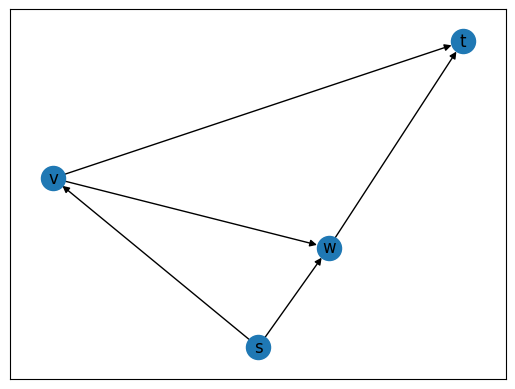

In [5]:
braess_paradox_bruteforce()

In [7]:
def braess_before_bruteforce():
    G, source_sink_pairs, demands, latency_functions = json_to_atomic_instance('graph_examples/braess_before.txt')
    paths, equil_flow, best_flow, min_total_latency = brute_force(G, source_sink_pairs, demands, latency_functions)
    print('All paths: ', paths)
    print('Equilibrium flows: ', equil_flow)
    print('best flow: ', best_flow)
    print('Minimum total latency: ', min_total_latency)

******** (0, 0) ********
player 0: path ['s', 'v', 't']
player 1: path ['s', 'v', 't']
{('s', 'v'): 2, ('v', 't'): 2}
8
******** (0, 1) ********
player 0: path ['s', 'v', 't']
player 1: path ['s', 'w', 't']
{('s', 'v'): 1, ('v', 't'): 1, ('s', 'w'): 1, ('w', 't'): 1}
6
******** (1, 0) ********
player 0: path ['s', 'w', 't']
player 1: path ['s', 'v', 't']
{('s', 'w'): 1, ('w', 't'): 1, ('s', 'v'): 1, ('v', 't'): 1}
6
******** (1, 1) ********
player 0: path ['s', 'w', 't']
player 1: path ['s', 'w', 't']
{('s', 'w'): 2, ('w', 't'): 2}
8
FOUND EQUILIBIRUM FLOW (0, 1)
FOUND EQUILIBIRUM FLOW (1, 0)
******************************
player 0: path ['s', 'w', 't']
player 1: path ['s', 'v', 't']
All paths:  [[['s', 'v', 't'], ['s', 'w', 't']], [['s', 'v', 't'], ['s', 'w', 't']]]
Equilibrium flows:  [(0, 1), (1, 0)]
best flow:  (1, 0)
Minimum total latency:  6


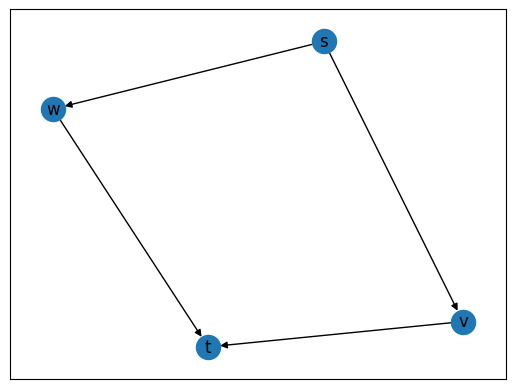

In [8]:
braess_before_bruteforce()